# Linear SVM, CSAR trining, Docking Scores, Pisani Residues

>

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Helper function
%run ./helper_functions_S6.ipynb

In [4]:
# Loading the data:
data_dir = '../data/docking_scores/'
# vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', 
             column_to_drop = 'ActiveInactive')
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
             column_to_drop = 'Actividad')
# Vianrdo Docking Scores (dksc) DEKOIS2
X_dksc_DEKOIS, y_dksc_DEKOIS = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
             column_to_drop = 'Actividad')

In [5]:
# Dictionary of docking results (Only DkSc are included)
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}}, 
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}}, 
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}}, 
             }

In [6]:
# Testing with the two following estimators
from sklearn.svm import SVC, LinearSVC

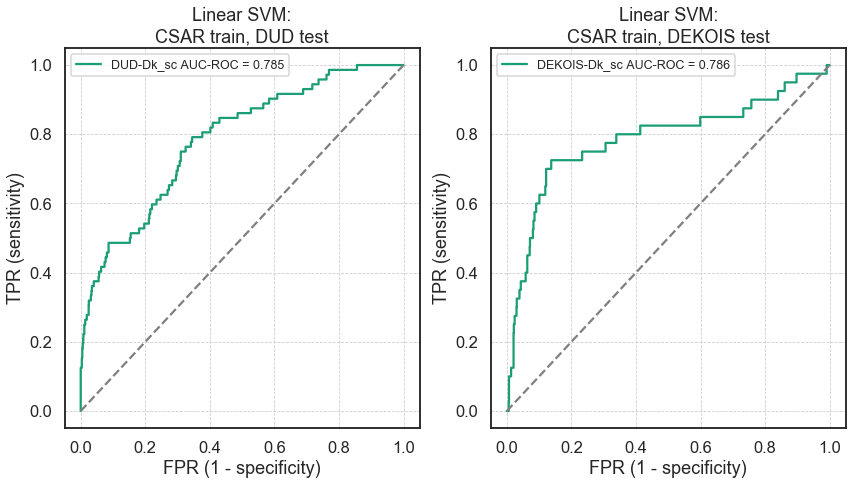

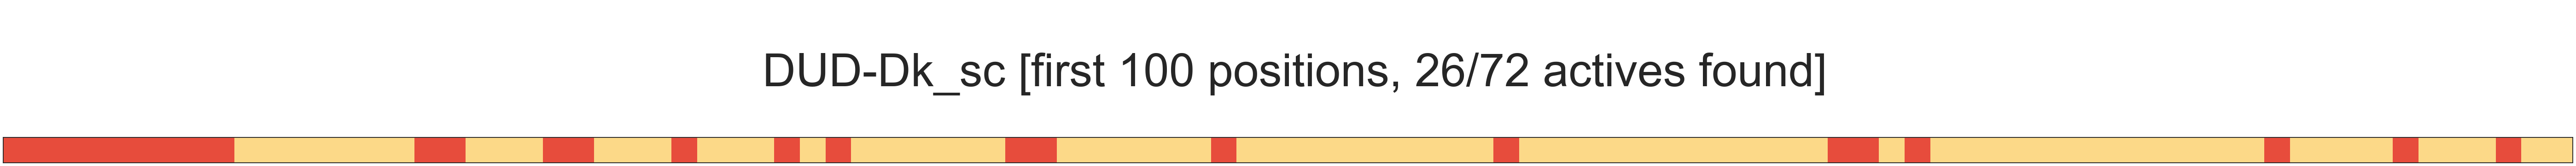

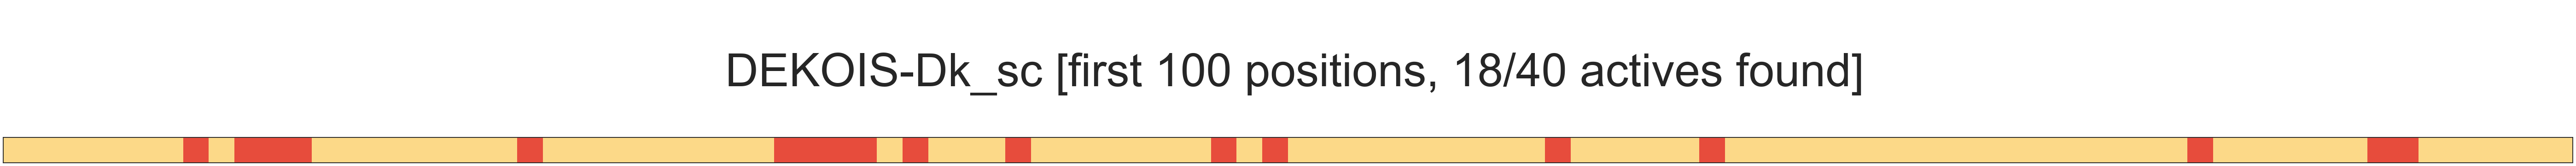

In [7]:
# first with SVC
# The best param found in the  grid search was C = 1
score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC


svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                               scores_dic = scores_dic, estimator = svm,
                               kernel = 'linear', probability = True, C = 0.1 )

svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = [score_type], 
                            scores_dic = scores_dic, decreasing = False)

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)


## Random Sampling:
Randomly choose n features for train and test.

In [8]:
import os
# Files to save the results
dud_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DUD_test.json'
dekois_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'

In [9]:
%%time

if not os.path.isfile(dud_file_rd):
    # Defining some variables and parameters
    score_type = 'Dk_sc'
    train_key = 'CSAR'
    test_keys = ['DUD', 'DEKOIS']
    C = 0.1
    model = SVC
    # Random picking parameters
    N_REPS = 50
    MIN_CONFS = 1
    MAX_CONFS = 402
    INTERVAL = 1

    # Then we create the dataframes to store the results
    list_of_columns = [F'rep_{i}' for i in range(N_REPS)]

    # Two dataframes, one for DUD and one for DEKOIS
    df_rdPick_DUD_lsvc = pd.DataFrame(columns = list_of_columns)
    df_rdPick_DEKOIS_lsvc = pd.DataFrame(columns = list_of_columns)


    # Run the loop
    for N_CONFS in range(MIN_CONFS, MAX_CONFS + 1, INTERVAL):
        if N_CONFS%(10) == 0:
             print(F'Iteración: {N_CONFS}')
        n_conf_row = random_confs_picking(scores_dic = scores_dic, score_type = score_type,
                                 train_key = train_key, test_keys = test_keys,
                                 n_features = N_CONFS, n_reps = N_REPS,
                                 # Exclusive hyperparameters for the selected model
                                 model = model, C = C, kernel = 'linear', probability = True)
        # Add the result to the corresponding row
        df_rdPick_DUD_lsvc.loc[ N_CONFS ] = n_conf_row['DUD']
        df_rdPick_DEKOIS_lsvc.loc[ N_CONFS ] = n_conf_row['DEKOIS']

CPU times: user 46 µs, sys: 10 µs, total: 56 µs
Wall time: 65.1 µs


In [10]:
# Save the results
if os.path.isfile(dud_file_rd):
    df_rdPick_DUD_lsvc = pd.read_json(dud_file_rd)
else:
    df_rdPick_DUD_lsvc.to_json()

if os.path.isfile(dekois_file_rd):
    df_rdPick_DEKOIS_lsvc = pd.read_json(dekois_file_rd)
else:
    df_rdPick_DEKOIS_lsvc.to_json()

### Plotting the results

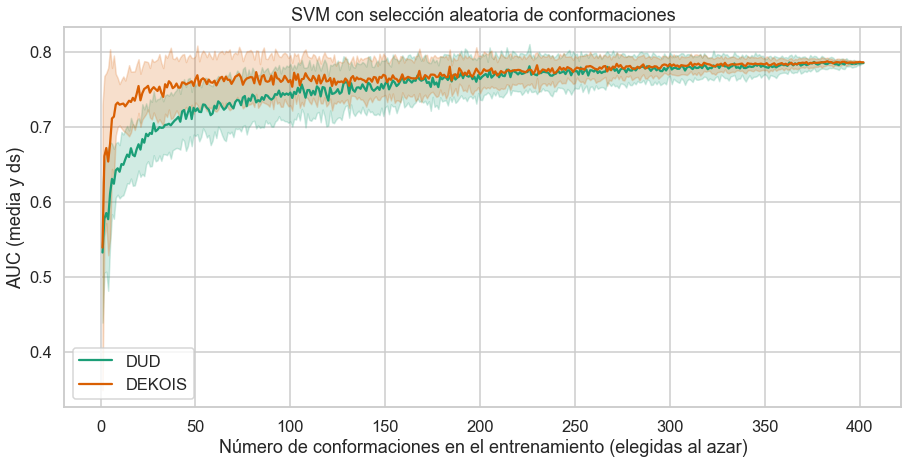

In [11]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')
plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

## K-means clustering

In [12]:
# Read the MDS resuts
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

#### Performs the k-means clustering

In [13]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
output_notebook()

Loading BokehJS ...

In [14]:
# Kmeans over the first two dimensions
fd = 2
_X = mds_pisani_402[0][:fd].T

n_clusters = 20
kmc = KMeans(n_clusters = n_clusters, random_state = 0)
kmc.fit( _X )

# Create the datasource
data_mds = ColumnDataSource({
    'x': _X.T[0],
    'y': _X.T[1],
    'cluster': kmc.labels_.astype('str')
})
CLUSTERS = np.unique(kmc.labels_.astype('str'))
color_map = factor_cmap('cluster', palette= viridis(len(CLUSTERS)), factors = CLUSTERS)

# Create the colors

f = figure(title = F'K-Means clustering (k = {n_clusters})', active_scroll='wheel_zoom')
# Plot the reference space
f.circle('x', 'y', color = color_map, source = data_mds, size = 6)

# Plot the centroids
f.triangle(x = kmc.cluster_centers_[:,0], 
           y = kmc.cluster_centers_[:,1], color = (220,20,60, 0.5), size = 10,
          line_color = 'black', legend_label = 'Centroids')
# Plot the medoids
medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = n_clusters,
                             random_state = 0)
_X_medoids = _X[ medoids_idx, :]
# Plot medoids
f.circle(x = _X_medoids.T[0], 
           y = _X_medoids.T[1], color = (255, 241, 116, 0), size = 10,
          line_color = 'black',  legend_label = 'Medoids')

show(f)

#### Elbow method using cluster inertia

In [15]:
K = 50
distortions = np.zeros(K)

for k in range(K):
    kmc = KMeans(n_clusters = k + 1, random_state = 0)
    kmc.fit(_X)
    distortions[k] = kmc.inertia_

In [16]:
f_2 = figure(title='Elbow method for kmeans clustering', plot_width = 900, plot_height = 300)
f_2.line(x = range(1, K+1), y = distortions)
f_2.circle(x = range(1, K+1), y = distortions)
f_2.xaxis.axis_label = 'k clusters'
f_2.yaxis.axis_label = 'Distortion'
show(f_2)

In [17]:
%%time

score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC
model_extra_params = dict(kernel = 'linear', probability = True, C = 0.1)
metric = 'roc_auc'

MAX_N_CONFS = 402

# Creates the dictionary of results to be filled and returned
# Saving to pandas dataframe
output_dir = '../data/ml_evaluations/'
file_name_kmeans = F'{output_dir}/KMEANS_sampling_1_to_402_features_CSAR_train_DUD_DKOIS_test_pisani_MDS'

if os.path.isfile(file_name_kmeans):
    # Load the file
    df_kmeans_results = pd.read_json(file_name_kmeans)
else: # Run the code and save the file
    results_dict = {}
    for test in test_keys:
        results_dict[test] = np.zeros(MAX_N_CONFS)


    for i in range(MAX_N_CONFS):
        # Selection of k conformations using K-Means
        k = i + 1
        medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = k,
                                     random_state = 0)
        features = scores_dic[train_key][score_type]['X'].columns[medoids_idx]

        # Performs the LinearSVC
        model_train = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                                    scores_dic = scores_dic, estimator = model,
                                    selected_features= features,
                                    **model_extra_params)

        model_pred = eval_wrapper(trained_model = model_train, 
                                    test_keys = test_keys, list_of_scores = [score_type], 
                                    selected_features= features,
                                    scores_dic = scores_dic, decreasing = False)

        for test in test_keys:
                metric_value = model_pred[test].format_metric_results(metric).values[0][0]
                results_dict[test][i] = metric_value

    df_kmeans_results = pd.DataFrame(results_dict)
    df_kmeans_results.to_json(file_name_kmeans)

CPU times: user 4.9 ms, sys: 3.66 ms, total: 8.56 ms
Wall time: 6.98 ms


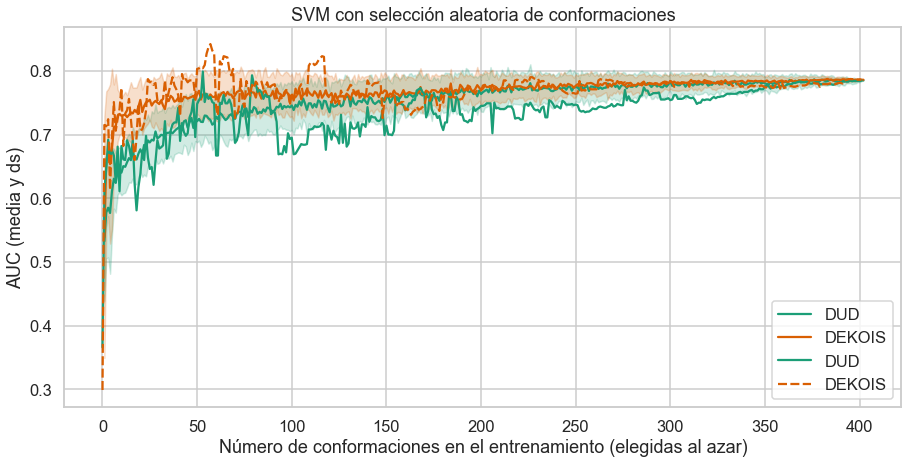

In [19]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')

#sns.lineplot(x = range(1, 403), y = results_dict['DEKOIS'], 
#             label = 'DEKOIS kmeans')
#sns.lineplot(x = range(1, 403), y = results_dict['DUD'], 
#             label = 'DUD kmeans')
sns.lineplot(data = df_kmeans_results)

plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

In [ ]:
df_kmeans_results